## 0. 학습 세팅

### 1) 메모리 정리

In [1]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

### 2) 수정된 코드 자동 업데이트

In [2]:
%load_ext autoreload
%autoreload 2
import foolbox as fb

### 3) Colab 환경 구성

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#===============구글 드라이브 경로 지정=======================================
%cd /content/drive/MyDrive/RetinaProject_final/RetinaProject
#=============================================================================

!pip install torchmetrics
!pip install optuna
!pip install foolbox

## 1. Load library

In [3]:
import os
import time
import copy
import numpy as np
"""
import json
import glob

import numpy as np
from PIL import Image

from torchmetrics.aggregation import MeanMetric
"""
import argparse
import easydict

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
"""
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
"""
import torchvision.transforms as T

from torch.utils.tensorboard import SummaryWriter
"""
import torch.utils.data as data
"""
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
from torch.utils.data import SubsetRandomSampler
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.functional.classification import accuracy

from src.models import vgg11_config, vgg13_config, vgg16_config, ConvNet
from src.models import VGG, get_vgg_layers
from src.engines import train, evaluate, get_predictions
from src.engines import plot_most_correct_wrong, epoch_time, normalize_image
from src.utils import load_checkpoint, save_checkpoint, save_transform, save_best_param

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
# GridSearch
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
import random
import numpy as np
import pandas as pd

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

In [5]:
best_valid_loss = float('inf')
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
grid_count = 0
n_trial = 1
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

def GridSearch_loop(trial: Trial) -> float:
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    global grid_count
    grid_count += 1
    print(f"================== {grid_count}번째 Grid ==================")
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    
    #==================================================================================================
    # 2. Variable Declaration
    #==================================================================================================
    # Jupyter 환경
    args = easydict.EasyDict({
            "title" : "VGG_Retina_ML_Grid_DCGAN1",
            "device" : "cuda",
            "root" : "data",
            "use_data" : "Retina_Some_binary_DCGAN", # Retina_Some_binary # Retina_Some_binary_GAN284 # Retina_Some_binary_GAN852 # Retina_student
            "batch_size" : 32, # !!!
            "num_workers" : 2,
            "epochs" : 100, # !!!
            #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
            # "lr" : 7.5e-5, # !!!
            "lr" : trial.suggest_loguniform("lr", 1e-6, 5e-5), # 1e-6, 5e-3 # 1e-6, 5e-5 !!!
            #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
            "logs" : "logs",
            "checkpoints" : "checkpoints",
            "transform_dir" : "transform_infor",
            "resume" : False,
            "train_ratio" : 0.8,
            "val_ratio" : 0.2,
            "test_ratio" : 1.0,
            "output_dim" : 2,
            "drop_rate": 0.5
        })
    
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    print("lr : ", args.lr)
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

    #==================================================================================================
    # 3. Image Data Preprocessing
    # 1) 이미지 변환
    #==================================================================================================
    # Build Dataset
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # transform 임의 선택(1 ~ 최대 개수) + 이미지 변환
    list_transforms = [T.RandomRotation(30), T.RandomHorizontalFlip(), T.RandomVerticalFlip(),
                        T.RandomAutocontrast(), T.RandomPerspective(fill=[255,255,255]), T.RandomInvert(), 
                        T.RandomGrayscale(p=0.5), T.RandomEqualize(), T.AutoAugment(T.AutoAugmentPolicy.IMAGENET)]
    """
    list_transforms = [T.RandomRotation(180), T.RandomHorizontalFlip(), T.RandomVerticalFlip(),
                    T.RandomAutocontrast(), T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
                    T.RandomAffine(180, shear=20), T.RandomPerspective(fill=[255,255,255]),
                    T.RandomGrayscale(p=0.5), T.RandomResizedCrop((256, 256))]
    """
    
    # rand_number_transform = random.randint(1, len(list_transforms)-1)
    rand_number_transform = random.randint(1, 3)
    rand_list_transforms = random.sample(list_transforms, rand_number_transform)

    train_transforms = T.Compose([
        T.Resize((256, 256)), # 이미지 크기 재조절
        *rand_list_transforms,
        T.ToTensor(),
        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    
    print("train_transforms : ", train_transforms)
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    """
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    train_transforms = T.Compose([
        T.Resize((256, 256)), # 이미지 크기 재조절
        T.RandomOrder([
            # T.RandomRotation(5), # 이미지 회전(5도 이하)
            # T.RandomHorizontalFlip(0.5), # 이미지 좌우 대칭(50% 확률)
    #         T.RandomRotation(180),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomAutocontrast(),
    #         T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
    #         T.RandomAffine(180, shear=20),
    #         T.RandomPerspective(fill=[255,255,255]),
    #         T.RandomGrayscale(p=0.5),
    #         T.RandomResizedCrop((256, 256)),
        ]),
        T.ToTensor(),
        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    """

    test_transforms = T.Compose([
        T.Resize((256, 256)), 
        T.ToTensor(),
        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    
    # transform 정보 저장
    save_transform(args.transform_dir, train_transforms, test_transforms, args.title)

    #==================================================================================================
    # 2) 이미지 데이터셋 불러오기 + 이미지 변환
    #==================================================================================================
    train_path = f'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\data\\{args.use_data}\\train' 
    test_path = f'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\data\\{args.use_data}\\test'
    
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    train_dataset = torchvision.datasets.ImageFolder(
        train_path, 
        transform = train_transforms
    )
    valid_dataset = torchvision.datasets.ImageFolder(
        train_path, 
        transform = test_transforms
    )
    test_dataset = torchvision.datasets.ImageFolder(
        test_path, 
        transform = test_transforms
    )
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

    train_dataset_classes = train_dataset.classes
    valid_dataset_classes = valid_dataset.classes
    test_dataset_classes = test_dataset.classes

    print("len(train_dataset) : ", len(train_dataset))
    print("train_dataset_classes : ", train_dataset_classes)
    print("train_dataset.__getitem__(18) : ", train_dataset.__getitem__(18))
    
    print("len(valid_dataset) : ", len(valid_dataset))
    print("valid_dataset_classes : ", valid_dataset_classes)
    print("valid_dataset.__getitem__(18) : ", valid_dataset.__getitem__(18))

    print("len(test_dataset) : ", len(test_dataset))
    print("test_dataset_classes : ", test_dataset_classes)
    print("test_dataset.__getitem__(18) : ", test_dataset.__getitem__(18))
    
    #==================================================================================================
    # 3) 훈련, 검증 데이터 분할 + 검증 이미지 재변환
    #==================================================================================================
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # 데이터 인덱스 랜덤 추출
    num_train_dataset = len(train_dataset)
    train_dataset_indices = list(range(num_train_dataset))
    np.random.shuffle(train_dataset_indices)
    split_idx = int(np.floor(args.val_ratio * num_train_dataset))
    train_idx, valid_idx = train_dataset_indices[split_idx:], train_dataset_indices[:split_idx]

    # 랜덤 배치 샘플러
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    """
    all_train_dataset_size = len(train_dataset)
    train_dataset_size = int(all_train_dataset_size * args.train_ratio)
    valid_dataset_size = all_train_dataset_size - train_dataset_size

    splited_train_dataset, splited_valid_dataset = random_split(train_dataset, [train_dataset_size, valid_dataset_size]) # 훈련 데이터셋, 검증 데이터셋 크기 결정

    splited_valid_dataset = copy.deepcopy(splited_valid_dataset)
    splited_valid_dataset.dataset.transform = test_transforms
    """
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

    #==================================================================================================
    # 4) 데이터 로드 to 메모리
    #==================================================================================================
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    train_loader = DataLoader(train_dataset,
                                batch_size = args.batch_size, 
                                sampler = train_sampler, 
                                num_workers=args.num_workers
                            )
    val_loader = DataLoader(valid_dataset,
                                batch_size = args.batch_size,
                                sampler = valid_sampler, 
                                num_workers=args.num_workers
                            )
    test_loader = DataLoader(test_dataset,
                                batch_size = args.batch_size,
                                num_workers=args.num_workers
                            )
    
    print(f"train_dataset 개수 : {len(train_dataset)}, " + f"train_loader 개수 : {len(train_loader)}") # train_data 개수, train_loader batch set 개수
    print(f"val_dataset 개수 : {len(valid_dataset)}, " + f"val_loader 개수 : {len(val_loader)}") # val_data 개수, val_loader batch set 개수
    print(f"test_dataset 개수 : {len(test_dataset)}, " + f"test_loader 개수 : {len(test_loader)}") # test_data 개수, test_loader batch set 개수
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    """
    train_loader = DataLoader(train_dataset,
                                shuffle = True
                                batch_size = args.batch_size, 
                                num_workers=args.num_workers
                            )
    val_loader = DataLoader(valid_dataset,
                                batch_size = args.batch_size,
                                num_workers=args.num_workers
                            )
    test_loader = DataLoader(test_dataset,
                                batch_size = args.batch_size,
                                num_workers=args.num_workers
                            )
    
    print(f"train_dataset 개수 : {len(splited_train_dataset)}, " + f"train_loader 개수 : {len(train_loader)}") # train_data 개수, train_loader batch set 개수
    print(f"val_dataset 개수 : {len(splited_valid_dataset)}, " + f"val_loader 개수 : {len(val_loader)}") # val_data 개수, val_loader batch set 개수
    print(f"test_dataset 개수 : {len(test_dataset)}, " + f"test_loader 개수 : {len(test_loader)}") # test_data 개수, test_loader batch set 개수
    """
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

    #==================================================================================================
    # 5) 시각화
    #==================================================================================================
    train_loader_iter = iter(train_loader)
    train_loader_images, train_loader_labels = train_loader_iter.next()

    test_loader_iter = iter(test_loader)
    test_loader_images, test_loader_labels = test_loader_iter.next()

    def imshow(img):
        np_img = img.numpy()
        plt.imshow(np.transpose(np_img, (1, 2, 0)))

        """
        print("np_img.shape : ", np_img.shape)
        print("(np.transpose(np_img, (1, 2, 0))).shape : ", (np.transpose(np_img, (1, 2, 0))).shape)
        """

    print("train_loader_labels : ", train_loader_labels)
    print("".join("%5s "%train_dataset_classes[train_loader_labels[j]] for j in range(32)))
    print("train_loader_images.shape : ", train_loader_images.shape)
    imshow(torchvision.utils.make_grid(train_loader_images, nrow=6))
    print("torchvision.utils.make_grid(train_loader_images).shape : ", torchvision.utils.make_grid(train_loader_images).shape)

    print("test_loader_labels : ", test_loader_labels)
    print("".join("%5s "%test_dataset_classes[test_loader_labels[j]] for j in range(32)))
    print("test_loader_images.shape : ", test_loader_images.shape)
    imshow(torchvision.utils.make_grid(test_loader_images, nrow=6))
    print("torchvision.utils.make_grid(test_loader_images).shape : ", torchvision.utils.make_grid(test_loader_images).shape)
    
    #==================================================================================================
    # 4. Model Define
    # 1) 모델 정의
    #==================================================================================================
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # Build model
    vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)
    model = VGG(vgg11_layers, args.output_dim)
    """
    model = ConvNet(drop_rate=args.drop_rate)
    """
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    model = model.to(args.device)

    #==================================================================================================
    # 2) 옵티마이저 + 손실함수 + 스케쥴러 + 메트릭 함수 정의
    #==================================================================================================
    # Build optimizer 
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # Build scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs * len(train_loader))

    # Build loss function
    loss_fn = nn.CrossEntropyLoss()

    # Build metric function
    """
    # 정확도 측정 함수
    def calculate_accuracy(y_pred, y): # ???
        top_pred = y_pred.argmax(1, keepdim = True)
        # print("top_pred : ", top_pred)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        # print("correct : ", correct)
        acc = correct.float() / y.shape[0]
        # print("acc : ", acc)
        return acc
    """
    metric_fn = accuracy

    #==================================================================================================
    # 3) logger 정의
    #==================================================================================================
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # Build logger
    train_logger = SummaryWriter(f'{args.logs}/train/{args.title}_{grid_count}')
    val_logger = SummaryWriter(f'{args.logs}/val/{args.title}_{grid_count}')
    test_logger = SummaryWriter(f'{args.logs}/test/{args.title}_{grid_count}')
    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

    #==================================================================================================
    # 5. Model Train
    # 1) Load model epoch
    #==================================================================================================
    # Load model
    start_epoch = 27
    if args.resume:
        start_epoch = load_checkpoint(args.checkpoints, args.title, model, optimizer)

    #==================================================================================================
    # 2) Train model
    #==================================================================================================
    for epoch in range(start_epoch, args.epochs):
        """
        # start timer
        start_time = time.time() # 확인용 코드
        """
        # 모델 학습 소요시간
        start_time = time.monotonic()

        # train one epoch + evaluate one epoch
        train_summary = train(train_loader, model, optimizer, scheduler, loss_fn, metric_fn, args.device)
        val_summary = evaluate(val_loader, model, loss_fn, metric_fn, args.device)

        # write log
        #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        train_logger.add_scalar(f'Loss_{args.lr}', train_summary['loss'], epoch + 1)
        train_logger.add_scalar(f'Accuracy_{args.lr}', train_summary['metric'], epoch + 1)
        val_logger.add_scalar(f'Loss_{args.lr}', val_summary['loss'], epoch + 1)
        val_logger.add_scalar(f'Accuracy_{args.lr}', val_summary['metric'], epoch + 1)
        #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        """
        #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        train_logger.add_scalar('Loss', train_summary['loss'], epoch + 1)
        train_logger.add_scalar('Accuracy', train_summary['metric'], epoch + 1)
        val_logger.add_scalar('Loss', val_summary['loss'], epoch + 1)
        val_logger.add_scalar('Accuracy', val_summary['metric'], epoch + 1)
        #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        """

        # 최적 loss인 model 저장
        global best_valid_loss
        if val_summary['loss'] < best_valid_loss:
            best_valid_loss = val_summary['loss']
            #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
            torch.save(model.state_dict(), f'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\best_valid_model\\{args.title}_{grid_count}.pt')
            save_best_param(args.transform_dir, train_transforms, test_transforms, args.lr, args.title)
        torch.save(model.state_dict(), f'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\best_valid_model\\{args.title}.pt')
            #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

        """
        #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        # save model
        save_checkpoint(args.checkpoints, args.title, model, optimizer, epoch + 1)
        #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        """

        # 모델 학습 소요시간
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Print log
        """
        print((
            f'[Epoch {epoch+1}] '
            + f'{epoch + 1}epoch time {end_time - start_time:.02f}, '
            + f'Train Loss {train_summary["loss"]:.04f}, '
            + f'Train Accuracy {train_summary["metric"]:.04f}, '
            + f'Test Loss {val_summary["loss"]:.04f}, '
            + f'Test Accuracy {val_summary["metric"]:.04f}'
        ))
        """
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t Train Loss: {train_summary["loss"]:.3f} | Train Acc: {train_summary["metric"]:.2f}%')
        print(f'\t Valid Loss: {val_summary["loss"]:.3f} | Valid Acc: {val_summary["metric"]:.2f}%')
        print(f'\t scheduled_lr : {scheduler.get_last_lr()[0]}')

    #==================================================================================================
    # 6. Model Test
    #==================================================================================================
    # 학습된 모델 불러오기
    model.load_state_dict(torch.load(f'C:\\Users\\Bang\\JupyterProjects\\RetinaProject\\DeepLearningPytorchExample\\best_valid_model\\{args.title}.pt'))

    # 모델 성능 측정
    test_summary = evaluate(test_loader, model, loss_fn, metric_fn, args.device)

    # write log
    test_logger.add_scalar('Loss', test_summary['loss'], epoch + 1)
    test_logger.add_scalar('Accuracy', test_summary['metric'], epoch + 1)

    print(f'Test Loss: {test_summary["loss"]:.3f} | Test Acc: {test_summary["metric"]:.2f}%')

    #==================================================================================================
    # 7. Model Prediction Print
    # 1) 예측한 값 추출 + 맞춘 이미지 정보 추출 + 틀린 이미지 정보 추출
    #==================================================================================================
    correct_examples, wrong_examples = get_predictions(test_loader, model, args.device)

#     for correct_example in correct_examples: # 확인용 코드
#         print("correct_example : ", correct_example[2])
#     for wrong_example in wrong_examples: # 확인용 코드
#         print("wrong_example : ", wrong_example[2])

    classes = test_dataset.classes
    n_images = 5
    plot_most_correct_wrong(correct_examples, wrong_examples, classes, n_images)

    #==================================================================================================
    # 3) return loss
    #==================================================================================================
    return val_summary["loss"]

[I 2022-12-04 20:32:02,969] A new study created in memory with name: Retina_opt
C:\Users\Bang\AppData\Local\Temp\ipykernel_19348\87400434.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "lr" : trial.suggest_loguniform("lr", 1e-6, 5e-5), # 1e-6, 5e-3 # 1e-6, 5e-5 !!!


================== 1번째 Grid ==================
lr :  4.328450221293881e-06
train_transforms :  Compose(
    Resize(size=(256, 256), interpolation=bilinear)
    RandomInvert(p=0.5)
    RandomPerspective(p=0.5)
    RandomAutocontrast(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
len(train_dataset) :  7592
train_dataset_classes :  ['DR', 'No_DR']
train_dataset.__getitem__(18) :  (tensor([[[-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_loader_labels :  tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 0])
No_DR    DR    DR    DR No_DR No_DR No_DR    DR    DR    DR    DR No_DR No_DR No_DR    DR No_DR    DR No_DR    DR No_DR No_DR No_DR No_DR No_DR    DR No_DR    DR    DR No_DR    DR    DR    DR 
train_loader_images.shape :  torch.Size([32, 3, 256, 256])
torchvision.utils.make_grid(train_loader_images).shape :  torch.Size([3, 1034, 2066])
test_loader_labels :  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
   DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR    DR 
test_loader_images.shape :  torch.Size([32, 3, 256, 256])
torchvision.utils.make_grid(test_loader_images).shape :  torch.Size([3, 1034, 2066])
Epoch: 28 | Epoch Time: 1m 6s
	 Train Loss: 0.691 | Tra

Epoch: 78 | Epoch Time: 1m 4s
	 Train Loss: 0.506 | Train Acc: 0.72%
	 Valid Loss: 0.514 | Valid Acc: 0.73%
	 scheduled_lr : 2.0962451571055917e-06
Epoch: 79 | Epoch Time: 1m 4s
	 Train Loss: 0.507 | Train Acc: 0.72%
	 Valid Loss: 0.507 | Valid Acc: 0.73%
	 scheduled_lr : 2.0283322915710476e-06
Epoch: 80 | Epoch Time: 1m 18s
	 Train Loss: 0.511 | Train Acc: 0.71%
	 Valid Loss: 0.508 | Valid Acc: 0.72%
	 scheduled_lr : 1.960553535842394e-06
Epoch: 81 | Epoch Time: 1m 4s
	 Train Loss: 0.509 | Train Acc: 0.72%
	 Valid Loss: 0.506 | Valid Acc: 0.72%
	 scheduled_lr : 1.8929757793685068e-06
Epoch: 82 | Epoch Time: 1m 4s
	 Train Loss: 0.507 | Train Acc: 0.72%
	 Valid Loss: 0.507 | Valid Acc: 0.73%
	 scheduled_lr : 1.8256657132362629e-06
Epoch: 83 | Epoch Time: 1m 4s
	 Train Loss: 0.505 | Train Acc: 0.72%
	 Valid Loss: 0.516 | Valid Acc: 0.73%
	 scheduled_lr : 1.7586897643544906e-06
Epoch: 84 | Epoch Time: 1m 4s
	 Train Loss: 0.506 | Train Acc: 0.72%
	 Valid Loss: 0.509 | Valid Acc: 0.72%
	 sc

[I 2022-12-04 21:52:31,877] Trial 0 finished with value: 0.509131908416748 and parameters: {'lr': 4.328450221293881e-06}. Best is trial 0 with value: 0.509131908416748.


Best Score: 0.509131908416748
Best trial: {'lr': 4.328450221293881e-06}


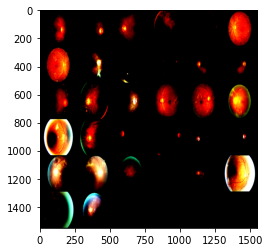

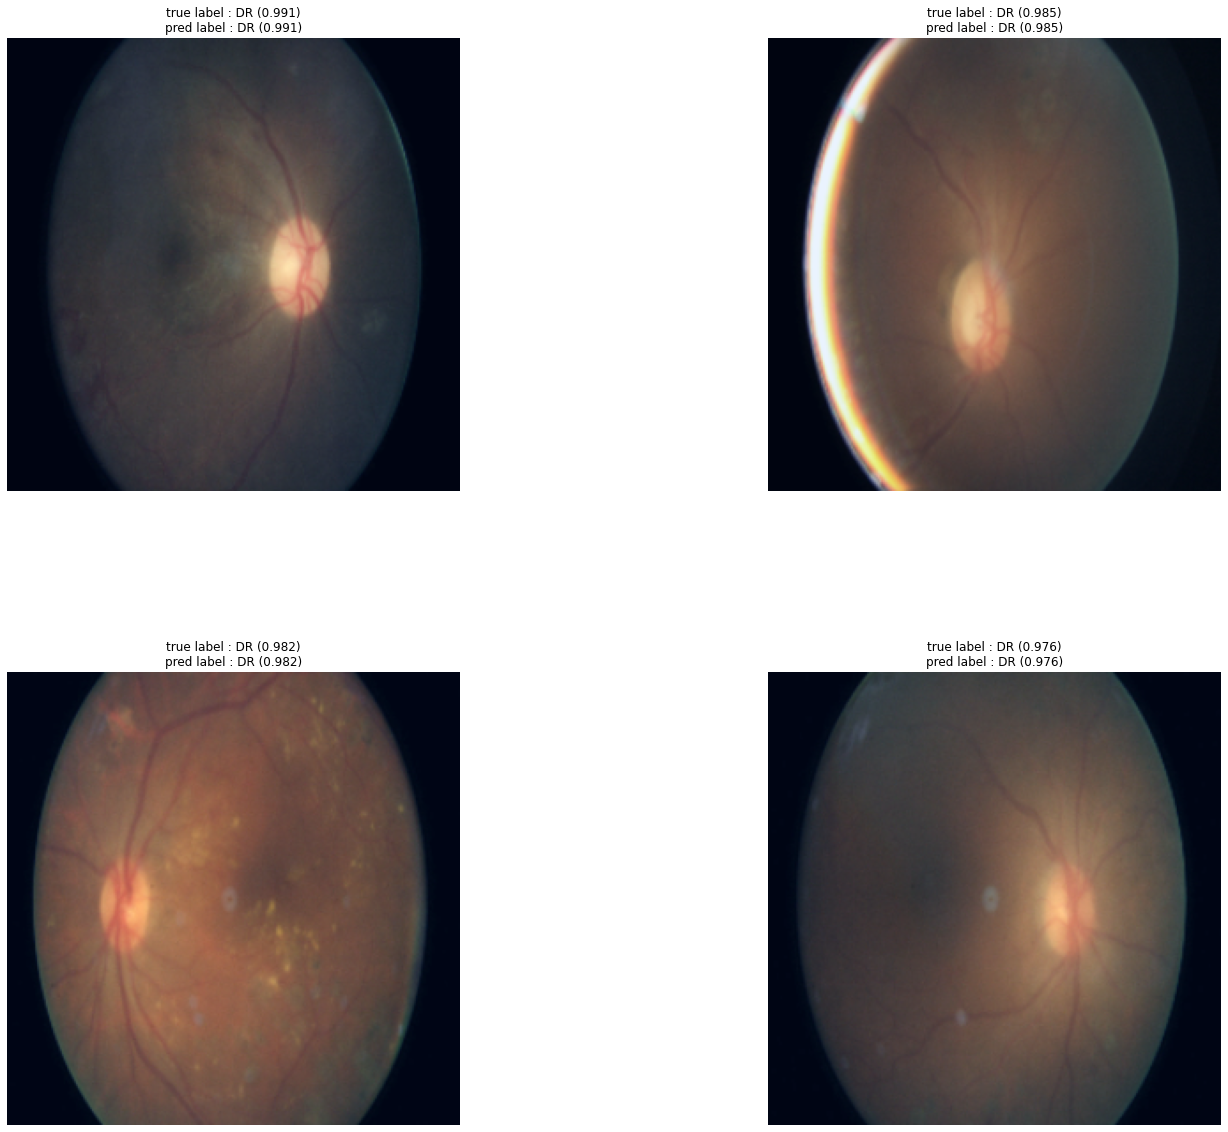

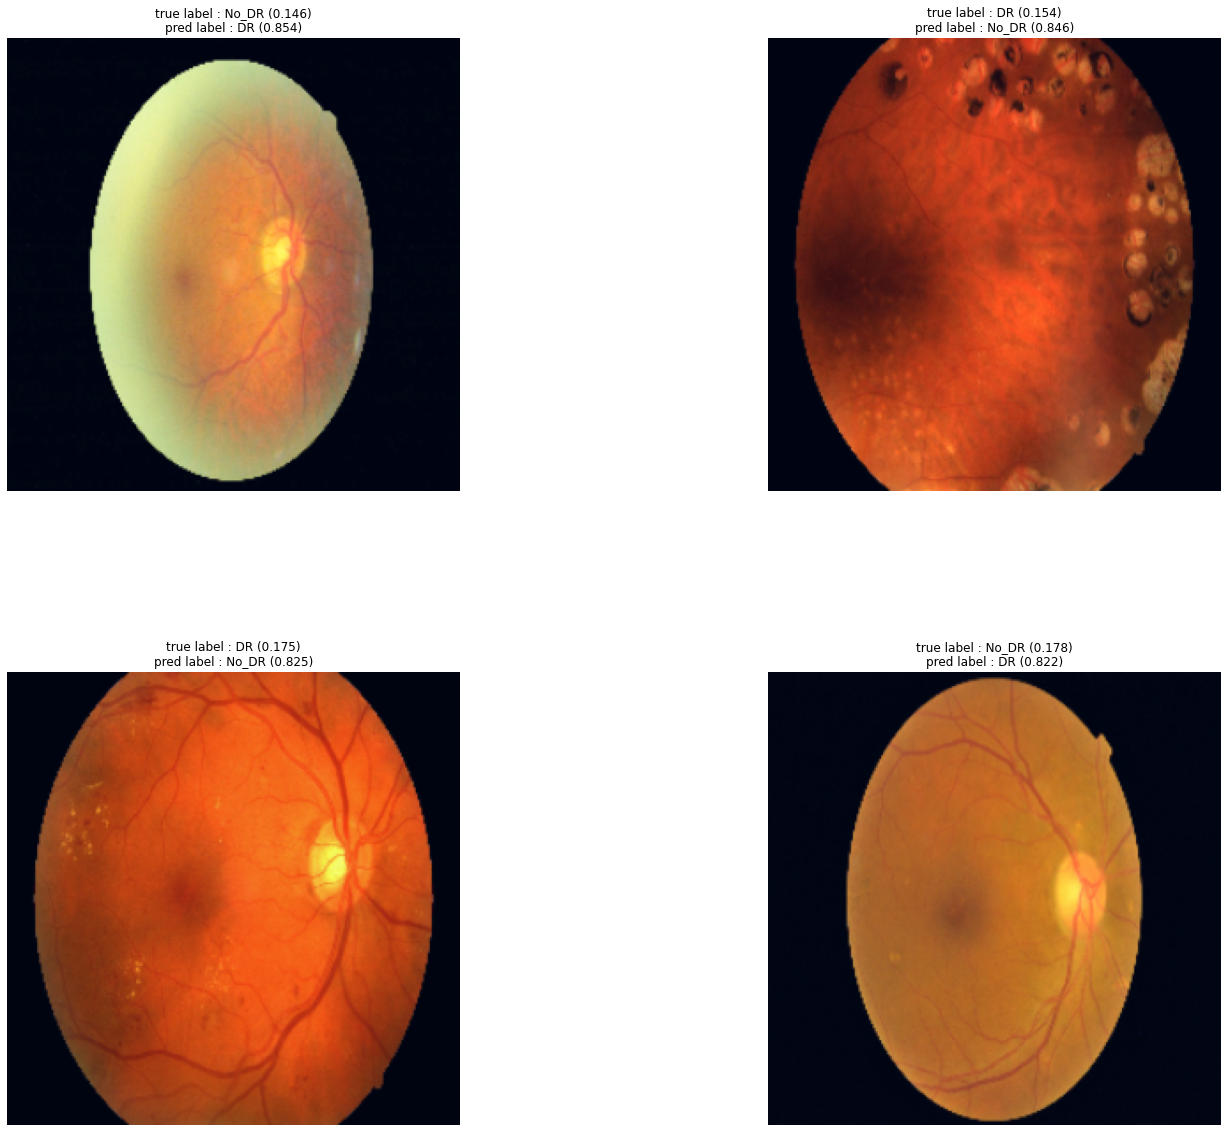

In [6]:
# GridSearch loop
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="Retina_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(GridSearch_loop, n_trials=n_trial)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ